In [2]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %                   SCF-TB - PROXY APPLICATION                      %
# %                   A.M.N. Niklasson, M. Kulichenko. T1, LANL       %
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Total Energy Function:                                            %
# % E = 2Tr[H0(D-D0)] + (1/2)*sum_i U_i q_i^2 +                       %
# %      + (1/2)sum_{i,j (i!=j)} q_i C_{ij} q_j - Efield*dipole       %
# % dipole = sum_i R_{i} q_i                                          %
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

import torch
import warnings
import logging
import os
# to disable torchdynamo completely. Faster for smaller systems and single-point calculations.
os.environ["TORCHDYNAMO_DISABLE"] = "1"  # hard-disable capture

import numpy as np
import matplotlib.pyplot as plt

from dftorch.SCF import SCFx, SCFx_batch
from dftorch.Constants import Constants
from dftorch.Structure import Structure, StructureBatch
from dftorch.MD import MDXL, MDXLBatch, MDXLOS
from dftorch.ESDriver import ESDriver, ESDriverBatch
from dftorch.Tools import calculate_dist_dips, fractional_matrix_power_symm, ordered_pairs_from_TYPE
from dftorch.H0andS import H0_and_S_vectorized

from sedacs.graph import get_initial_graph
from dftorch.Tools import calculate_dist_dips
from dftorch.XLTools import kernel_update_lr, kernel_update_lr_os, kernel_update_lr_batch, calc_q, calc_q_os, calc_q_batch

from sedacs.graph_partition import get_coreHaloIndices, graph_partition, get_coreHaloIndicesPYSEQM

#from sedacs.ewald import calculate_PME_ewald, init_PME_data, calculate_alpha_and_num_grids, ewald_energy
from dftorch.ewald_pme import calculate_PME_ewald, init_PME_data, calculate_alpha_and_num_grids, ewald_energy
from dftorch.ewald_pme.neighbor_list import NeighborState
from dftorch.nearestneighborlist import vectorized_nearestneighborlist

from dftorch.io import write_XYZ_trajectory, write_xyz_from_xyz

### Configure torch and torch.compile ###
# Silence warnings and module logs
warnings.filterwarnings("ignore")
os.environ["TORCH_LOGS"] = ""               # disable PT2 logging
os.environ["TORCHINDUCTOR_VERBOSE"] = "0"
os.environ["TORCHDYNAMO_VERBOSE"] = "0"
logging.getLogger("torch.fx").setLevel(logging.CRITICAL)
logging.getLogger("torch.fx.experimental.symbolic_shapes").setLevel(logging.CRITICAL)
logging.getLogger("torch.fx.experimental.recording").setLevel(logging.CRITICAL)
# Enable dynamic shape capture for dynamo
torch._dynamo.config.capture_dynamic_output_shape_ops = True
# default data type
torch.set_default_dtype(torch.float64)

torch.cuda.empty_cache()

In [3]:
%%time
dftorch_params = {
    'coul_method': 'PME', # 'FULL' for full coulomb matrix, 'PME' for PME method
    'Coulomb_acc': 5e-5,   # Coulomb accuracy for full coulomb calcs or t_err for PME
    'cutoff': 10.0,        # Coulomb cutoff
    'PME_order': 4,        # Ignored for FULL coulomb method

    'SCF_MAX_ITER': 100,    # Maximum number of SCF iterations
    'SCF_TOL': 1e-6,       # SCF convergence tolerance on density matrix
    'SCF_ALPHA': 0.3,      # Scaled delta function coefficient. Acts as linear mixing coefficient used before Krylov acceleration starts.

    'KRYLOV_MAXRANK': 20,  # Maximum Krylov subspace rank
    'KRYLOV_TOL': 1e-6,    # Krylov subspace convergence tolerance in SCF
    'KRYLOV_TOL_MD': 1e-4, # Krylov subspace convergence tolerance in MD SCF
    'KRYLOV_START': 3,     # Number of initial SCF iterations before starting Krylov acceleration
                }
                
# Initial data, load atoms and coordinates, etc in COORD.dat
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cuda'
#filename = '8RNT.xyz'      
#filename = '2AS9.xyz'

# filename = 'COORD_far.xyz'            # Solvated acetylacetone and glycine molecules in H20, Na, Cl
# LBox = torch.tensor([25.0, 25.0, 25.0], device=device) # Simulation box size in Angstroms. Only cubic boxes supported for now.

filename = 'COORD_8WATER.xyz'            # Solvated acetylacetone and glycine molecules in H20, Na, Cl
LBox = torch.tensor([30.0, 30.0, 30.0], device=device) # Simulation box size in Angstroms. Only cubic boxes supported for now.

# filename = 'water_30.xyz'            # Solvated acetylacetone and glycine molecules in H20, Na, Cl
# LBox = torch.tensor([35.0, 35.0, 35.0], device=device) # Simulation box size in Angstroms. Only cubic boxes supported for now.



# Create constants container. Set path to SKF files.
const = Constants(filename,
                  #'/home/maxim/Projects/DFTB/DFTorch/tests/sk_orig/ptbp/complete_set',
                  #'C:\\000_MyFiles\\Programs\\DFTorch\\tests\\sk_orig\\ptbp\\complete_set\\',
                  '/home/maxim/Projects/DFTB/DFTorch/tests/sk_orig/mio-1-1/mio-1-1/',
                  magnetic_hubbard_ldep=False
                  ).to(device)

# Create structure object. Define total charge and electronic temperature.
structure1 = Structure(filename, LBox, const, charge=0, Te=5000.0, device=device)

# Create ESDriver object and run SCF calculation
# electronic_rcut and repulsive_rcut are in Angstroms.
# They should be >= cutoffs defined in SKF files for the element pair with largest cutoff present in the system.
es_driver = ESDriver(dftorch_params, electronic_rcut=8.0, repulsive_rcut=6.0, device=device)
es_driver(structure1, const, do_scf=True)
es_driver.calc_forces(structure1, const) # Calculate forces after SCF

torch.float64 torch.int64
### Do SCF ###
  Initial DM_Fermi
mu0 initial: tensor(-1.1798, device='cuda:0')
Initial q_global: tensor([ 0.7797, -0.3903, -0.3939,  0.7779, -0.3867, -0.3858,  0.7608, -0.3802,
        -0.3798,  0.7503, -0.3830, -0.3752,  0.7635, -0.3766, -0.3792,  0.7607,
        -0.3797, -0.3802,  0.7676, -0.3822, -0.3853,  0.7363, -0.3681, -0.3708],
       device='cuda:0')

Starting cycle
Iter 1
Res = 0.737648151, dEc = 0.909540472, t = 0.0 s

Iter 2
Res = 0.450400174, dEc = 2.065619992, t = 0.0 s

Iter 3
Res = 0.275412043, dEc = 1.112903955, t = 0.0 s

Iter 4
  rank: 0, Fel = 0.001347
  rank: 1, Fel = 0.000082
  rank: 2, Fel = 0.000003
  rank: 3, Fel = 0.000000
Res = 0.168605944, dEc = 1.540267637, t = 0.0 s

Iter 5
  rank: 0, Fel = 0.000001
Res = 0.000071660, dEc = 3.070911205, t = 0.0 s

Iter 6
  rank: 0, Fel = 0.000000
Res = 0.000001869, dEc = 0.001143612, t = 0.0 s

Iter 7
  rank: 0, Fel = 0.000000
Res = 0.000000075, dEc = 0.000007777, t = 0.0 s

CPU times: user 3.79 

In [4]:
structure1.e_band0, structure1.e_entropy, structure1.e_repulsion, structure1.e_coul, structure1.e_tot

(tensor(-907.2538, device='cuda:0'),
 tensor(-1.4685e-05, device='cuda:0'),
 tensor(17.0793, device='cuda:0'),
 tensor(3.8008, device='cuda:0'),
 tensor(-886.3738, device='cuda:0'))

tensor(7.4113e-08)


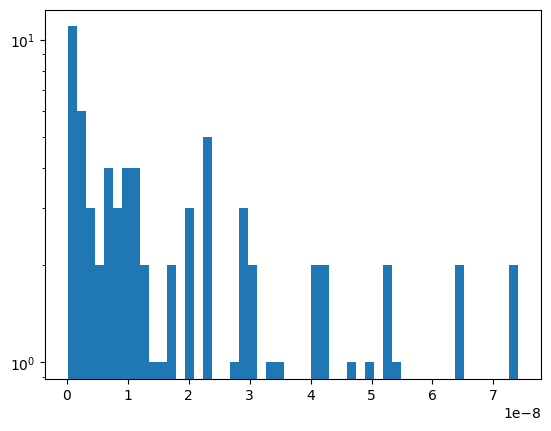

In [6]:
f_tot_graph = torch.load('f_tot.pt')
f_dif = (structure1.f_tot.cpu() - f_tot_graph).abs().flatten().numpy()
plt.hist(f_dif, bins=50, )
plt.yscale("log")
print((structure1.f_tot.cpu() - f_tot_graph).abs().max())

In [7]:
structure1.f_rep, structure1.f_coul

(tensor([[ -1.5768,   1.2188,   0.3580,  -5.8069,   4.8888,   0.9181,   5.8452,
           -7.9012,   2.0559,   0.4163,   0.6705,  -1.0868,  -0.7844,   7.0523,
           -6.2679,  -0.1453,  -0.9513,   1.0966,   7.7791,  -7.2576,  -0.5215,
           11.9129,  -6.4946,  -5.4183],
         [ -4.6452,   6.7791,  -2.1339,   0.6390,   2.9331,  -3.5721,  -6.4365,
            1.5814,   4.8551, -14.3503,   2.7081,  11.6422,   8.3916,  -7.4518,
           -0.9399,   3.3038,   4.2203,  -7.5241,   1.8677,   2.8961,  -4.7638,
          -10.4422,  16.6011,  -6.1588],
         [ -5.0064,   1.9342,   3.0722,   5.7769,   1.0765,  -6.8534,   6.2376,
            0.6628,  -6.9004, -10.0713,  -3.3879,  13.4592, -11.2180,   7.4800,
            3.7380, -10.0854,   7.9349,   2.1505,   6.3774,  -5.9988,  -0.3786,
          -13.5262,   7.7862,   5.7400]], device='cuda:0'),
 tensor([[ 0.0539, -0.0285, -0.0345,  0.4549, -0.2908, -0.1558, -0.3484,  0.3815,
           0.0151,  0.1504, -0.0548, -0.0309, -0.1919, -

In [7]:
structure1.q

tensor([ 0.5885, -0.3051, -0.3014,  ...,  0.6628, -0.2931, -0.3201])

In [6]:
structure1.mu0, structure1.Nocc

(tensor(1.1308), 3536)

In [100]:
H0 = torch.load("H0_0.pt")
H0

tensor([[-23.9142,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,  -9.0378,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,  -9.0378,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,  -9.0378,   0.7972,  -2.8292],
        [  0.0000,   0.0000,   0.0000,  ...,   0.7972,  -6.4926,  -2.5742],
        [  0.0000,   0.0000,   0.0000,  ...,  -2.8292,  -2.5742,  -6.4926]])

In [101]:
structure1.H0

tensor([[-23.9142,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,  -9.0378,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,  -9.0378,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,  -9.0378,   0.7972,  -2.8292],
        [  0.0000,   0.0000,   0.0000,  ...,   0.7972,  -6.4926,  -2.5742],
        [  0.0000,   0.0000,   0.0000,  ...,  -2.8292,  -2.5742,  -6.4926]])

In [102]:
(structure1.H0 - H0).abs().max()

tensor(6.5725e-14)